# Исследование данных о работе сервиса аренды самокатов


Исследование проходит на данных от популярного сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться с подпиской и без подписки. В зависимости от этого, у пользователей разные стоимость старта, стоимость 1 минуты пользования и абонентская плата.

**Цель исследования**: проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**План исследования:**
 1. Загрузка данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных
 4. Объединение данных из трех датафреймов в один массив, сравнение основных характеристик пользователей с подпиской и без
 5. Подсчет выручки
 6. Проверка гипотез
 7. Общий вывод


In [1]:
# импортируем все необходимые для анализа библиотеки
import pandas as pd # импортируем библиотеку pandas 
import matplotlib.pyplot as plt #импортируем библиотеку matplotlib 
import numpy as np #импортируем библиотеку numpy 
from scipy import stats as st #импортируем модуль stats из библиотеки scipy

# 1. Загрузка данных

In [2]:
# считываем исходные данные

users_go = pd.read_csv('users_go.csv')
riders_go = pd.read_csv('rides_go.csv')
subscriptions_go = pd.read_csv('subscriptions_go.csv')

Ознакомимся с данными, представленными в каждой таблице.

In [3]:
users_go.head(10) # выведем первые 10 строчек таблицы с данными о пользователях

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users_go.info() # вызовем метод info для знакомства с параметрами таблицы с данными о пользователях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
riders_go.head(10) # выведем первые 10 строчек таблицы с данными о поездках

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
riders_go.info() # вызовем метод info для знакомства с параметрами таблицы с данными о поездках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


И выведем таблицу с данными о подписках. Выводим полностью, так как видов подписки у нас всего два:

In [7]:
subscriptions_go 

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:**

На первом шаге нашего исследования мы считали исходные данные из файлов и поближе с ними познакомились. На входе у нас имеются три таблицы разных размеров: с данными о пользователях сервиса, с данными о поездках и с данными о подписках (всего два вида). 

# 2. Предобработка данных

##### 2.1 Изменение типов данных

На предыдущем шаге было выявлено, что в таблице **riders_go** с данными о поездках, даты поездок представлены в формате *object*. С таким типом данных будет тяжело работать в дальнейшем. Приведем данные в столбце **date** к типу *DateTime*.

In [8]:
riders_go['date'] = pd.to_datetime(riders_go['date'], format='%Y-%m-%d')

Проверим, удалась ли корректировка, вызывав метод *info*.

In [9]:
riders_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### 2.2 Обработка пропущенных значений и дубликатов

Проверим массивы данных о пользователях и поездках на наличие пропусков.

In [10]:
users_go.isna().sum() # проверяем таблицу с данными о пользователях

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
riders_go.isna().sum() # проверяем таблицу с данными о поездках

user_id     0
distance    0
duration    0
date        0
dtype: int64

Таблицу с данными о подписках проверять не будем - там всего две строчки, наличие пропусков можно оценить визуально. 

Теперь проверим таблицы **users_go** и **riders_go** на наличие явных и неявных дубликатов.

In [12]:
users_go.duplicated().sum() # проверяем таблицу с данными о пользователях

31

In [13]:
riders_go.duplicated().sum() # проверяем таблицу с данными о поездках

0

Выявлены явные дубликаты в таблицы с данными о пользователях. Количество строк с дубликатами небольшое - меньше 2% от общего объема данных. Можем удалить этистроки. 

In [14]:
users_go = users_go.drop_duplicates().reset_index(drop=True)

Дополнительно проверим на наличие дубликатов столбец с ID пользователей. 

In [15]:
users_go.duplicated('user_id').sum() 

0

Дубликатов не обнаружено. Повторяющихся значений в столбце с ID нет.

Выявление неявных дубликатов возможно только в таблице с данными о пользователях. А именно в столбце с названием города.

In [16]:
users_go['city'].unique() 

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Никаких опечаток или разных регистров - неявных дубликатов в столбце не обнаружено.

##### 2.3 Создание дополнительных столбцов

Введем в таблицу с данными о поездках дополнительный столбец с номером месяца. Этот параметр понадобится нам при дальнейшем анализе. 

In [17]:
riders_go['month'] = riders_go['date'].dt.month

In [18]:
riders_go.head() # сделаем проверку и выведем первые 5 строк таблицы с riders_go

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Вывод:**

В ходе предобработки исходных массивов тип данных в столбце **date** в таблице с информацией о поездках был изменен на формат *DateTime*. Пропусков ни в одной из трех таблиц выявлено не было. Также как и неявных дубликатов. Зато были обнаружены явные -  в таблице с данными о пользователях. Строки-дубликаты было принято решение удалить, так как их количество не превышало 2% от общего количества строк в указанной таблице.  

# 3. Исследовательский анализ данных

Исследуем данные о пользователях и поездках более пристально.

##### 3.1 Анализ информации о пользователях

Перед тем как начать более детальный анализ данных о пользователях, вспомним какую информацию содержит указанный датафрейм:

In [19]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


###### 3.2 Присутствие сервиса в разных городах

Начнем с анализа распространенности сервиса в разных городах. 

Сгруппируем данные по названию города и посчитаем, как часто те или иные города встречаются в таблице:

In [20]:
users_go.groupby('city')['user_id'].count().sort_values(ascending= False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

Для наглядности также построим график с частотностью городов.

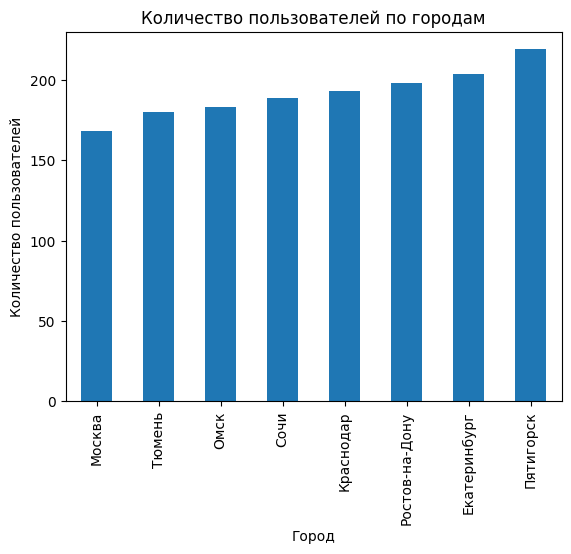

In [21]:
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id').plot(kind='bar', legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Город')
plt.title('Количество пользователей по городам')
plt.show()

Наибольшее количество пользователей сервиса *GoFast* проживают в Пятигорске - 219 человек. Немного отстает Екатеринбург - 204 пользователя. Тройку лидеров завершает Ростов-на-Дону - 204 пользователя. Удивительно плохо представлена в выборке Москва. 

В целом можно сказать, что пользователи распределены по городам присутствия достаточно равномерно. Разброс между максимальным и минимальным количеством пользователей небольшой - 41 человек. 

###### 3.3 Пользователи с подписками и без

Проанализируем количество пользователей сервиса с подпиской и без нее.

In [22]:
users_go.groupby('subscription_type')['user_id'].count() # сгруппируем данные по типу подписки и выведем 
# соответствующее количество пользователей

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

In [23]:
users_go.groupby('subscription_type')['user_id'].count()/len(users_go) # посчитаем доли пользователей с 
# подпиской и без

subscription_type
free     0.544329
ultra    0.455671
Name: user_id, dtype: float64

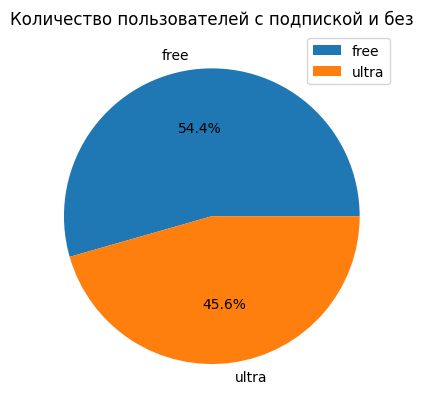

In [24]:
# выведем диаграмму по количеству пользователей с подпиской и без

users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count').\
plot.pie(y='user_id', autopct='%.1f%%')
plt.title('Количество пользователей с подпиской и без')
plt.ylabel('')
plt.show()

Больше половины пользователей сервиса пользуются им без оформления подписки. Количество людей с подпиской на 8.8% меньше, чем без нее.

###### 3.4 Возраст пользователей

Выведем на экран диаграмму возрастов пользователей: 

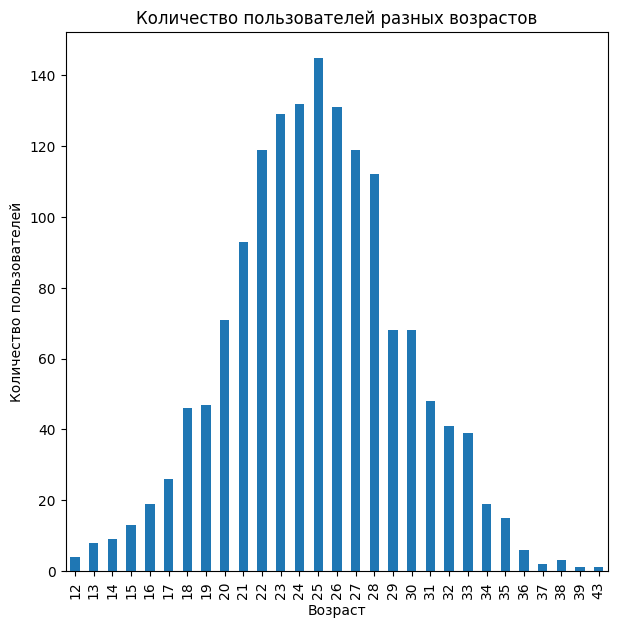

In [25]:
users_go.pivot_table(index='age', values='user_id', aggfunc='count').plot(kind='bar', figsize=(7,7), legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.title('Количество пользователей разных возрастов')
plt.show()

Опишем основные параметры распределения пользователей по возрастам:

In [26]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Медианный возраст пользователя сервиса - 25 лет. Этот же возраст является наиболее часто встречающимся. Есть среди пользоватлей несовершеннолетние. В целом чаще всего сервисом пользуется молодежь в возрасте от 22 до 28 лет. Самому старшему пользователю в выборке - 43 года.

##### 3.4 Анализ информации о поездках

Перед началом анализа данных о поездках вспомним, какие данные представлены в таблице:

In [27]:
riders_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


###### 3.5 Расстояние, которое пользователь преодолел за одну поездку

Посмотрим, как различается расстояние, преодолеваемое пользователем от поездки к поездке.

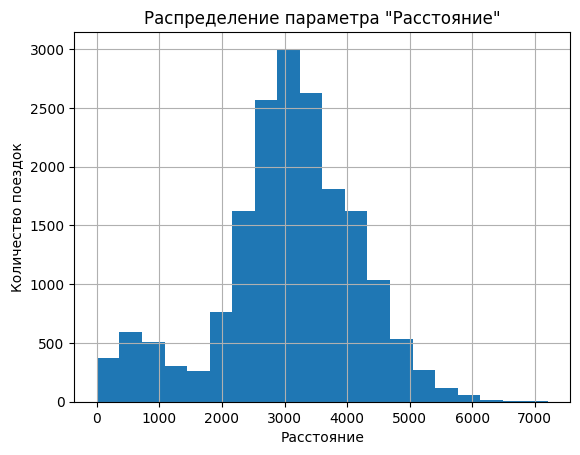

In [28]:
riders_go.hist('distance', bins=20)
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.title('Распределение параметра "Расстояние"')
plt.show()

Опишем основные параметры распределения дистанций по каждой поездке:

In [29]:
riders_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Стандартное расстояние, преодолеваемое пользователем за одну сессию составляет около 3 километров. Большинство поездок совершались на расстояние от 2.5 до 3.8 километров. Есть рекордные заезды дальностью до 7 километров. Некоторые поездки аномально короткие - минимальное расстояние, преодолеваемое за одну сессию, составляет меньше метра.

Немного пристальнее взглянем на наиболее короткие заезды.

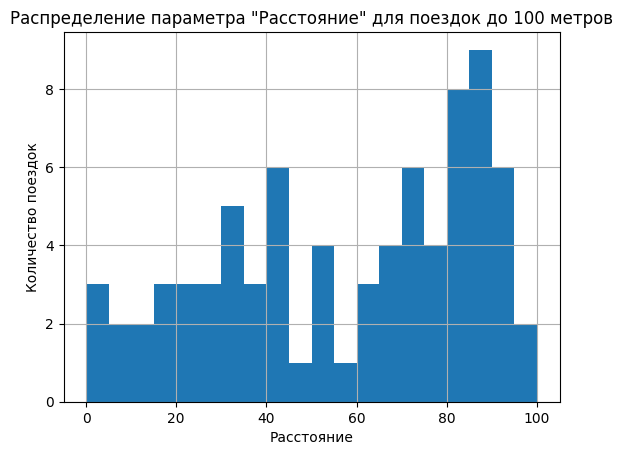

In [30]:
riders_go.hist('distance', bins=20, range=(0,100)) # построим гистограмму по предельному расстоянию 100 метров
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.title('Распределение параметра "Расстояние" для поездок до 100 метров')
plt.show()

In [31]:
riders_go.query('distance<100')['user_id'].count() # посчитаем общее количество поездок до 100 метров

78

Видно, что поездок с аномально небольшим пройденным расстоянием достаточно большое количество. Вряд ли это связано с тем, что пункт назначения пользователя находился слишком близко. Иных причин может быть множество: сложность управления самокатом, неисправность транспорта. Кроме того, такой показатель может сигнализировать о том, что пользователю сложно разобраться с интерфейсом приложения и с функционалом сервиса.

######  3.6 Продолжительность поездок

Теперь сравним , как отличаются данные о пройденном расстоянии от данных о продолжительности поездок.

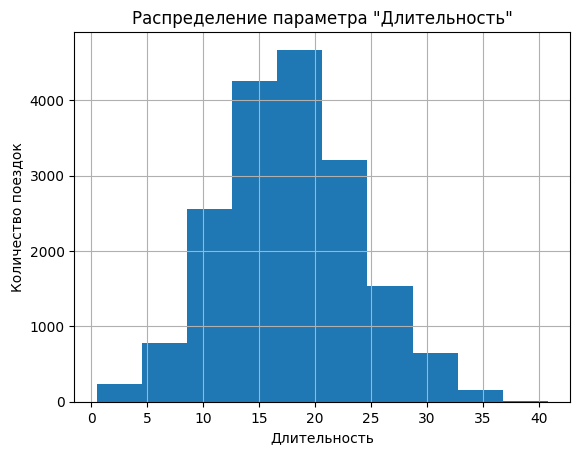

In [32]:
riders_go.hist('duration') # построим гистограмму по данным о длительности поездок 
plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.title('Распределение параметра "Длительность"')
plt.show()

In [33]:
riders_go['duration'].describe() # опишем основные параметры распределения длительности поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Длительность стандартной поездки на самокате сервиса *GoFast* составляет 18 минут. Большинство поездок длятся от 14 до 22 минут. Максимальное время поездки - 40 минут. Достаточно большое количество поездок с длительностью приближенной к нулю. Изучим их чуть внимательнее. 

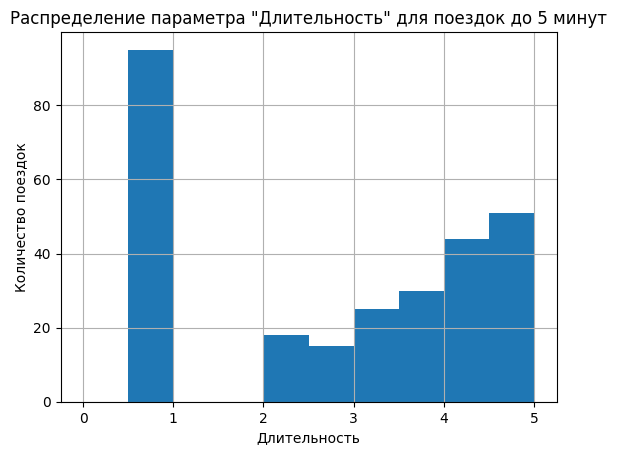

In [34]:
riders_go.hist('duration', range=(0,5)) # построим гистограмму по предельной длительности поездок в 5 минут
plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.title('Распределение параметра "Длительность" для поездок до 5 минут')
plt.show()

Более 80 поездок не продлились и 1 минуты. Возможно, это примерно те же поездки, что и с преодоленным расстоянием до 100 метров.

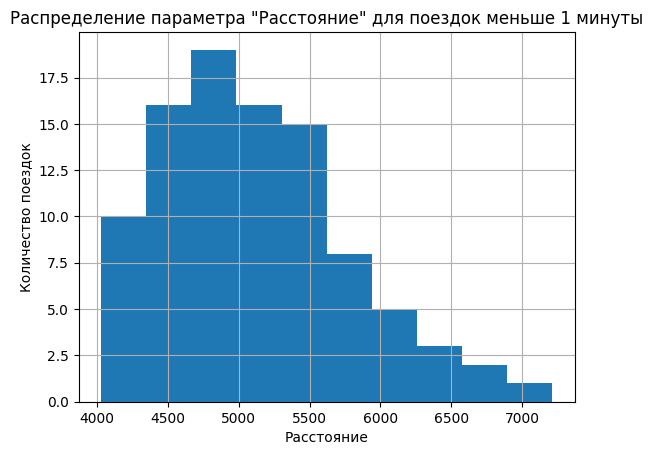

In [35]:
riders_go.query('duration<1')['distance'].hist() # отфильтруем данные по длительности поездки до минуты и построим
# гистограмму по преодоленному пользователем расстоянию
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.title('Распределение параметра "Расстояние" для поездок меньше 1 минуты')
plt.show()

In [36]:
riders_go.query('duration<1').head(20) # еще раз выведем 20 первых строк таблицы с данными о поездках, 
# отфильтровав их по длительности до 1 минуты

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
6860,724,6225.520342,0.5,2021-12-16,12
6883,726,4452.491518,0.5,2021-03-01,3
7018,735,4406.954812,0.5,2021-04-13,4
7160,745,5286.167732,0.5,2021-08-17,8
7364,760,4881.391865,0.5,2021-08-29,8


Кажется, здесь какая-то ошибка. При длительности поездки меньше минуты некоторые пользователи умудряются проехать несколько километров пути. Кажется, наш сервис считает время поездки не совсем корректно. 

**Вывод:**

Наибольшее количество пользователей сервиса *GoFast* проживают в Пятигорске. При этом, в целом можно сказать, что пользователи распределены по городам присутствия достаточно равномерно. Разброс между максимальным и минимальным количеством пользователей в разных городах небольшой - 41 человек. 

Больше половины пользователей сервиса пользуются им без оформления подписки.

Сервис пользуется популярностью у молодежи в возрасте от 22 до 28 лет. Средний возраст пользователя - 25 лет. 

Стандартное расстояние, преодолеваемое пользователем за одну сессию составляет около 3 километров. При этом в массиве присутствуют данные об аномально коротких поездках - 100 метров и меньше. Возможными причинами таких заездов могут быть: сложность управления самокатом, неисправность транспорта, неинтуитивный интерфейс приложения, проблемы с функционалом сервиса.

Длительность стандартной поездки на самокате сервиса *GoFast* составляет 18 минут. Более 80 поездок не продлились и 1 минуты. При этом пройденное расстояние для таких поездок может составлять несколько километров. Это может указывать на ошибки в расчетах времени поездки сервисом. 

# 4. Объединение данных

Для дальнейшего исследования объединим имеющиеся у нас три датафрейма в один, используя метод *merge*.

In [37]:
# объединим таблицы с данными о пользователях и поездках

total_go = riders_go.merge(users_go, on='user_id', how = 'left') 

In [38]:
# объединим таблицу с данными о пользователях и поездках с данными о подписках

total_go = total_go.merge(subscriptions_go, on='subscription_type', how='left')

Выведем на экран первые несколько строк получившейся после слияния таблицы.

In [39]:
total_go.head() 

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Теперь разделим получившийся датафрем на два новых массива: на данные о пользователях с подпиской и без нее.

In [40]:
ultra_users = total_go.query('subscription_type=="ultra"')
ultra_users.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [41]:
free_users = total_go.query('subscription_type=="free"')
free_users.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Познакомимся с общими характеристиками вновь образовавшихся датафреймов:

In [42]:
ultra_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int32         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB


In [43]:
free_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int32         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


Теперь изучим информацию о расстоянии и времени поездок для пользователей обеих категорий.

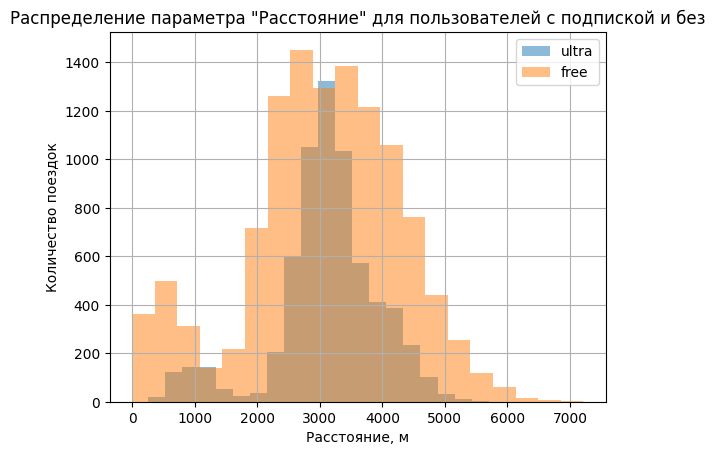

In [44]:
# построим гистограмму по данным о расстоянии поездок пользователей с подпиской
ultra_users['distance'].hist(bins=20, label = 'ultra', alpha=0.5)    
    
# построим гистограмму по данным о расстоянии поездок пользователей без подписки
free_users['distance'].hist(bins=20, label = 'free', alpha=0.5)    

plt.title('Распределение параметра "Расстояние" для пользователей с подпиской и без')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()
    

In [45]:
ultra_users['distance'].describe() # выведем на экран основные характеристики распредления дальности поездок 
# пользователей с подпиской

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [46]:
free_users['distance'].describe() # выведем на экран основные характеристики распредления дальности поездок 
# пользователей без подписки

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Стандартная дальность поездки для обеих групп примерно одинакова - 3 километра. Аномально короткие и длинные поездки чаще встречаются у пользователей, не имеющих подписку. Разброс данных во второй таблице вдвое больше.

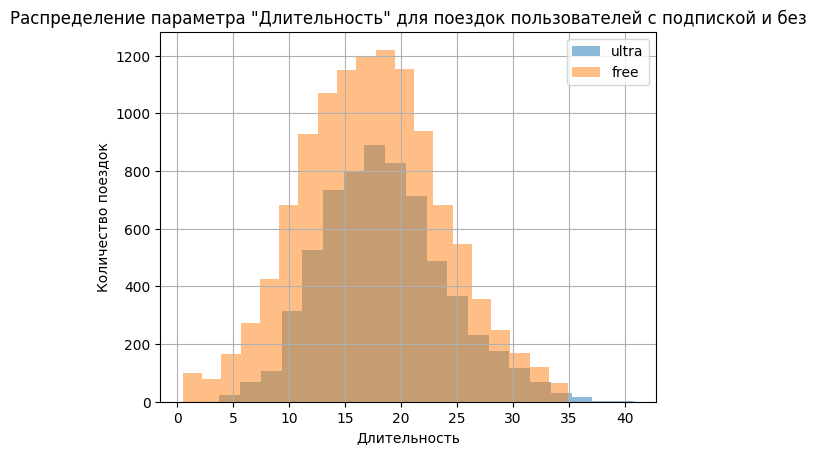

In [47]:
# построим гистограмму по данным о длительности поездок пользователей с подпиской
ultra_users['duration'].hist(bins=20, label = 'ultra', alpha=0.5)    
    
# # построим гистограмму по данным о длительности поездок пользователей без подписки
free_users['duration'].hist(bins=20, label = 'free', alpha=0.5)    

plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.title('Распределение параметра "Длительность" для поездок пользователей с подпиской и без')
plt.legend()
plt.show()

In [48]:
ultra_users['duration'].describe() # выведем на экран основные характеристики распредления дальности поездок 
# пользователей с подпиской

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [49]:
free_users['duration'].describe() # выведем на экран основные характеристики распредления дальности поездок 
# пользователей без подписки

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

Среднее время поездок для обеих групп примерно одинаково и составляет около 17-18 минут. В целом, длительность поездок для разных групп пользователей выглядит довольно схожей, кроме наличия у группы пользователей без подписки аномально коротких поездок меньше минуты. 

**Вывод:**

Для дальнейшего анализа, путем двухэтапного преобразования, из исходных данных мы получили два новых массива: с информацией о поездках пользователей, имеющих подписку, и с информацией о поездках пользователей, использующих сервис без нее. Первый датафрейм получился практически вдвое меньше, чем второй.

Проанализировав данные о дальности и длительности поездок пользователей разных групп, мы пришли к выводу, что в данных о поездках пользователей без подписок больше аномальных значений. Так, для этой группы характерны аномально короткие и длинные поездки. А также непродолжительные поездки меньше минуты.  

# 5. Подсчёт выручки

Посчитаем стоимость каждой поездки и внесем полученное значение в новый столбец общего массива данных обо всех поездках **total_go**. 

In [50]:
# для начала округлим значения в столбце с длительностью поездки 
total_go['duration'] = np.ceil(total_go['duration']) 

Теперь сгруппируем данные по месяцам и рассчитаем суммарные дистанцию, время и количество поездок.

In [51]:
total_monthly = total_go.groupby(['user_id', 'month']).\
agg({'distance': 'sum', 'duration': 'sum', 'name':'count'})
total_monthly.head()

distance  duration  name
user_id month                             
1       1      7027.511294      42.0     2
        4       754.159807       7.0     1
        8      6723.470560      46.0     2
        10     5809.911100      32.0     2
        11     7003.499363      56.0     3

В коде выше мы считали количество поездок в месяц для каждого пользователя, считая, сколько раз встречается его имя в отфильтрованных строчках. Переименуем колонку с названием **name** на **quantuty** (с англ. "количество").

In [52]:
total_monthly = total_monthly.rename(columns={'name':'quantity'}) 
total_monthly.head()

distance  duration  quantity
user_id month                                 
1       1      7027.511294      42.0         2
        4       754.159807       7.0         1
        8      6723.470560      46.0         2
        10     5809.911100      32.0         2
        11     7003.499363      56.0         3

In [53]:
total_monthly = total_monthly.reset_index() # изменим индексы в сводной таблице, чтобы работать с user_id
# как со столбцом

Добавим в таблицу с месячными показателями для каждого пользователя информацию о стоимости старта поездки, стоимости минуты пользования и стоимости подписки. 

In [54]:
total_monthly = pd.merge(total_monthly, total_go[['user_id', 'start_ride_price', 'minute_price', 'subscription_fee']].\
drop_duplicates(), on=['user_id'], how='left')
total_monthly.head()

,user_id,month,distance,duration,quantity,start_ride_price,minute_price,subscription_fee
0,1,1,7027.511294,42.0,2,0,6,199
1,1,4,754.159807,7.0,1,0,6,199
2,1,8,6723.470560,46.0,2,0,6,199
3,1,10,5809.911100,32.0,2,0,6,199
4,1,11,7003.499363,56.0,3,0,6,199


Посчитаем месячную выручку для каждого пользователя и запишем ее в новый столбец:

In [55]:
total_monthly['revenue'] = (total_monthly['start_ride_price']*total_monthly['quantity']+
                            total_monthly['minute_price']*total_monthly['duration']+
                           total_monthly['subscription_fee'])
total_monthly.head()

,user_id,month,distance,duration,quantity,start_ride_price,minute_price,subscription_fee,revenue
0,1,1,7027.511294,42.0,2,0,6,199,451.0
1,1,4,754.159807,7.0,1,0,6,199,241.0
2,1,8,6723.470560,46.0,2,0,6,199,475.0
3,1,10,5809.911100,32.0,2,0,6,199,391.0
4,1,11,7003.499363,56.0,3,0,6,199,535.0


**Вывод:**

По итогам выполнения Шага 5, мы сформировали сводную таблицу с данными о месячной выручке, принесенной каждым пользователем. Она будет использована при проверке гипотез, которые могут помочь бизнесу вырасти.

# 6. Проверка гипотез

##### 6.1 Время поездок пользователей с подпиской и без

Проверим, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без нее. Нулевой гипотезой в данном случае может выступать утверждение: время поездки пользователя с подпиской (t1) = времени поездки пользователя без подписки (t2). Альтернативная гипотеза: t1**>**t2.

Используем *ttest* для проверки односторонней гипотезы о равенстве средних двух генеральных совокупностей, обозначив дополнительный параметр *alternative* - альтернативную гипотезу.

In [56]:
results_1 = st.ttest_ind(ultra_users['duration'], free_users['duration'], alternative='greater')

Посчитаем вероятность того, что среднее время в пути пользователя с подпиской будет равно среднему времени в пути пользователя без подписки:

In [57]:
results_1.pvalue

1.2804098316645618e-34

Сравним ее со статистической значимостью равной 0.05:

In [58]:
results_1.pvalue<0.5

True

Вероятность такого события меньше статистически значимой. Значит нулевую гипотезу мы отвергаем: среднее время поездки пользователя с подпиской действительно больше среднего времени поездки пользователя без подписки.

##### 6.2 Расстояние, преодолеваемое пользователями с подпиской

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

Нулевой гипотезой в данном случае выступит утверждение: среднее расстояние, преодолеваемое пользователями с подпиской за одну поездку (S) = 3130 метров. Альтернативная гипотеза: S>3130.

Используем *ttest* для проверки односторонней гипотезы о равенстве  заданного значения среднему расстоянию преодолеваемому пользователем с подпиской за одну поездку.

In [59]:
max_distance = 3130
results_2 = results = st.ttest_1samp(ultra_users['distance'], max_distance, alternative='greater')

Посчитаем вероятность того, что среднее расстояние преодолеваемое пользователем с подпиской за одну поездку равно 3130 метрам:

In [60]:
results_2.pvalue

0.9195368847849785

Cравним ее со статистической значимостью равной 0.05:

In [61]:
results_2.pvalue<0.05

False

Значение p-value больше 0,05. Нулевая гипотеза не опровергнута.
Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, статистически не превышает 3130 метров. 

##### 6.3 Помесячная выручка от разных групп пользователей

Проверим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Нулевая гипотеза в данном случае может быть сформулирована так: выручка от пользователей с подпиской равна выручке от пользователей без нее. Альтернативная гипотеза: месячная выручка от пользователей с подпиской выше месячной выручки от пользоватлей без подписки.

Проверить нулевую гипотезу мы можем используя знакомый *ttest* для проверки односторонней гипотезы о равенстве средних двух генеральных совокупностей. Обозначим наши генеральные совокупности, отфильтровав данные таблицы **total_monthly** по стоимости подписки и выбрав столбец с помесячной выручкой. 

In [62]:
# задаем генеральную совокупность с данными о помесячной выручке от пользователей с подпиской
gen_ultra = total_monthly.loc[total_monthly['subscription_fee']==199, 'revenue']

# задаем генеральную совокупность с данными о помесячной выручке от пользователей без подписки
gen_free = total_monthly.loc[total_monthly['subscription_fee']==0, 'revenue']

In [63]:
# используем ttest
results_3 = st.ttest_ind(gen_ultra, gen_free, alternative='greater')

Посчитаем вероятность того, что средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки:

In [64]:
results_3.pvalue

1.8850394384715216e-31

И сравним ее со статистической значимостью равной 0.05:

In [65]:
results_3.pvalue<0.05

True

Вероятность такого события меньше статистически значимой. Нулевая гипотеза не подтвердилась. Средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки. 

**Вывод:**

Проверка гипотез показала, что вероятнее всего среднее время поездки пользователя с подпиской действительно больше среднего времени поездки пользователя без подписки. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, а значит этот вид пользователей больше склонен совершать поездки оптимальные для износа самоката. Средняя помесячная выручка от пользователей с подпиской также выше, чем от пользователей без подписки. 

Таким образом, пользователи с подпиской действительно "выгоднее" для сервиса.

# 7. Общий вывод

В ходе исследования мы работали с данными, предоставленными популярным сервисом аренды самокатов GoFast. Анализу была подвергнута информация о некоторых пользователях из нескольких городов, а также об их поездках.

По результатам предобработки исходных данных были выявлены следующие проблемы:
 1. некорректный тип данных в таблице с информацией о поездках - был скорректирован на на формат *DateTime*;
 2. явные дубликаты в таблице с данными о пользователях - были удалены, количество не превышало 2% от общего количества строк в указанной таблице.
 
Наибольшее количество пользователей сервиса *GoFast* проживают в Пятигорске. Хуже всего сервис представлен в Москве.

Больше половины пользователей сервиса пользуются им без оформления подписки. Наибольшей популярностью сервис пользуется популярностью у молодежи в возрасте от 22 до 28 лет. Средний возраст пользователя - 25 лет. 

Стандартное расстояние, преодолеваемое пользователем за одну сессию составляет около 3 километров. Данное расстояние является оптимальным для равномерного износа самоката. В то же время, достаточно много поездок дальностью 100 метров и меньше.  Возможными причинами таких заездов могут быть: сложность управления самокатом, неисправность транспорта, неинтуитивный интерфейс приложения, проблемы с функционалом сервиса.

Длительность стандартной поездки на самокате сервиса *GoFast* составляет 18 минут. Более 80 поездок не продлились и 1 минуты. При этом пройденное расстояние для таких поездок может составлять несколько километров. Это может указывать на ошибки в данных, в расчетах времени поездки сервисом или на махинации пользователей. 

Проверка гипотез показала, что пользователи с подпиской "выгоднее" для сервиса. На данный момент их меньшинство. Для роста бизнеса необходимо проводить разнообразные акции для стимуляции приобретения подписки на сервис.

Кроме того, о необходимости увеличения числа пользователей с подпиской, говорит наличие разнообразных аномалий в данных о поездках пользователей без подписки. Так, для пользователей без подписки наиболее характерны аномально короткие и длинные поездки. А также непродолжительные поездки меньше минуты. 

По итогам всего выше сказаного, помимо увеличения числа подписок, для улучшения работы сервиса (и, как следствие, для роста выручки), можно провести следующие мероприятия:
- дополнительное исследование причин поездок на небольшие расстояния (до 100 метров);
- проверка системы расчета времени поездки;
- определение путей защиты приложения от мошенников, искусственно занижающих время поездки.